In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

In [2]:
with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']
    test_y = X['test_y']


In [3]:
print("nucleotides: {}".format(set(data_x[0])))

nucleotides: {'C', 'G', 'T', 'A'}


In [8]:
def one_hot_nucleotides(inp):
    for x in inp:
        if x == 'C':
            yield np.array([1, 0, 0, 0], dtype=np.float32)
        if x == 'G':
            yield np.array([0, 1, 0, 0], dtype=np.float32)
        if x == 'T':
            yield np.array([0, 0, 1, 0], dtype=np.float32)
        if x == 'A':
            yield np.array([0, 0, 0, 1], dtype=np.float32)

In [9]:
data_x_onehot = np.array([
    np.array([x for x in one_hot_nucleotides(data_x[i])]) for i in range(len(data_x))
])
val_x_onehot = np.array([
    np.array([x for x in one_hot_nucleotides(val_x[i])]) for i in range(len(val_x))
])
test_x_onehot = np.array([
    np.array([x for x in one_hot_nucleotides(test_x[i])]) for i in range(len(test_x))
])

In [6]:
device = torch.device('cuda')

In [7]:
batch_size = 10
n_input = 4
n_classes = 5

In [8]:
class RNN(nn.Module):

    def __init__(self, input_size, n_classes):
        super().__init__()
        self.cell1 = nn.RNNCell(input_size, 50)
        self.cell2 = nn.RNNCell(50, 40)
        self.cell3 = nn.RNNCell(40, 30)
        self.to_class = nn.Sequential(
            nn.Linear(30, 150),
            nn.LeakyReLU(),
            nn.Linear(150, 75),
            nn.LeakyReLU(),
            nn.Linear(75, n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inputs, hidden1=None, hidden2=None, hidden3=None):
        r""" Expects inputs of shape [batch size, sequence length, input] """
        out = None
        for x in torch.unbind(inputs, dim=1):
            hidden1 = self.cell1(x, hidden1)
            hidden2 = self.cell2(hidden1, hidden2)
            hidden3 = self.cell3(hidden2, hidden3)
            out = hidden3
        # out is now the latest hidden state
        pred = self.to_class(out)
        return pred

In [9]:
rnn = RNN(n_input, n_classes).to(device)

In [10]:
loss = nn.NLLLoss().to(device)

In [11]:
n_epochs = 150

In [12]:
n_batches = len(data_x_onehot) // batch_size

In [13]:
opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)

In [14]:
losses = []
losses_val = []
accuracies_val = []

In [15]:
ix = np.arange(len(data_x_onehot))

In [16]:
for epoch in tqdm(range(n_epochs)):
    np.random.shuffle(ix)
    
    rnn.train()
    
    batch_losses = []
    for batch in range(n_batches):
        opt.zero_grad()
        
        indices = ix[batch*batch_size:(batch+1)*batch_size]
        x_batch = torch.from_numpy(data_x_onehot[indices]).to(device)
        y_batch = torch.from_numpy(data_y[indices]).to(device)
        
        prediction = rnn(x_batch)
        loss_value = loss(prediction, y_batch)
        loss_value.backward()
        
        opt.step()
        
        batch_losses.append(loss_value.detach().cpu().numpy())
    losses.append(np.mean(batch_losses))
    
    rnn.eval()
    with torch.no_grad(): 
        prediction_val = rnn(torch.from_numpy(val_x_onehot).to(device))
        loss_val = loss(prediction_val, torch.from_numpy(val_y).to(device))
        losses_val.append(loss_val.cpu().numpy())
        prediction_val_labels = np.argmax(prediction_val.cpu().numpy(), axis=1)
        accuracy_val = (1. - np.count_nonzero(np.array(prediction_val_labels) - val_y) / len(prediction_val_labels))*100.
        accuracies_val.append(accuracy_val)
        
    print(f"Epoch {epoch+1}/{n_epochs}: Loss {losses[-1]:.3f} Val loss {losses_val[-1]:.3f}" 
          f" Accuracy {accuracies_val[-1]:.0f}%")

Epoch 1/150: Loss 1.611 Val loss 1.609 Accuracy 18%
Epoch 2/150: Loss 1.607 Val loss 1.606 Accuracy 17%
Epoch 3/150: Loss 1.602 Val loss 1.601 Accuracy 19%
Epoch 4/150: Loss 1.595 Val loss 1.591 Accuracy 32%
Epoch 5/150: Loss 1.579 Val loss 1.568 Accuracy 41%
Epoch 6/150: Loss 1.535 Val loss 1.501 Accuracy 46%
Epoch 7/150: Loss 1.423 Val loss 1.373 Accuracy 42%
Epoch 8/150: Loss 1.285 Val loss 1.229 Accuracy 52%
Epoch 9/150: Loss 1.109 Val loss 0.994 Accuracy 57%
Epoch 10/150: Loss 0.933 Val loss 0.850 Accuracy 67%
Epoch 11/150: Loss 0.810 Val loss 0.748 Accuracy 72%
Epoch 12/150: Loss 0.720 Val loss 0.684 Accuracy 77%
Epoch 13/150: Loss 0.667 Val loss 0.653 Accuracy 69%
Epoch 14/150: Loss 0.624 Val loss 0.607 Accuracy 73%
Epoch 15/150: Loss 0.611 Val loss 0.578 Accuracy 82%
Epoch 16/150: Loss 0.580 Val loss 0.606 Accuracy 72%
Epoch 17/150: Loss 0.618 Val loss 0.553 Accuracy 73%
Epoch 18/150: Loss 0.547 Val loss 0.505 Accuracy 82%
Epoch 19/150: Loss 0.498 Val loss 0.481 Accuracy 82%
Ep

KeyboardInterrupt: 

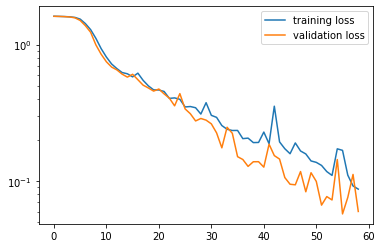

In [23]:
plt.semilogy(losses, label='training loss')
plt.semilogy(losses_val, label='validation loss')
plt.legend();

In [24]:
with torch.no_grad():
    prediction_test = rnn(torch.from_numpy(test_x_onehot).to(device))
    pred = np.argmax(prediction_test.cpu().numpy(), axis=1)
    accuracy = (1. - np.count_nonzero(np.array(pred) - test_y) / len(pred))*100.
print(f"Test accuracy: {accuracy}%")

Test accuracy: 97.2%
